# Imports

In [26]:
!pip install numpy pandas matplotlib plotly scipy scikit-image scikit-learn torch torchvision kagglehub
!pip install nbformat

In [27]:
import os
import shutil
import numpy as np
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp
import skimage as sk
from skimage import io
from scipy import ndimage
from shutil import copyfile
#from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
#from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import LearningRateScheduler
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from itertools import islice
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn

# Load core libraries and utilities
import numpy as np
from sklearn.cluster import KMeans
from skimage import color



In [28]:
import kagglehub

dataset_path = kagglehub.dataset_download("cyx6666/coil20")
print(f"Dataset downloaded to: {dataset_path}")


Dataset downloaded to: /Users/amelia/.cache/kagglehub/datasets/cyx6666/coil20/versions/1


## Matt's Contribution

### Code from Homeworks 2 and 3
### New function `build_dataset_with_existing_function()`

In [29]:

def gray_scale_convert(image):
    if len(image.shape) == 3:
        return color.rgb2gray(image)
    else:
        # Convert to float and normalize in one step
        image_float = image.astype(np.float64)
        min_val = np.min(image_float)
        max_val = np.max(image_float)

        if max_val > min_val:
            return (image_float - min_val) / (max_val - min_val)
        else:
            return np.zeros_like(image_float)

# We need to be able to pass in a directory and build an image list
def file_builder(directory):
    image_list = []
    # iterate over files in
    # that directory
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename != "Readme":
                input_image = gray_scale_convert(np.squeeze(io.imread(os.path.join(root, filename))) )
                image_list.append( input_image )
    return image_list

# NEW FUNCTION. Creates a dataset of both dogs and cats using the existing `file_builder` and `gray_scale_convert` functions.
def build_dataset_with_existing_function(base_directory):
    """
    Uses existing file_builder function with original gray_scale_convert
    for directories named 1-20
    """

    all_images = []
    all_labels = []

    # Loop through directories 1 to 20
    for class_id in range(1, 21):
        class_dir = os.path.join(base_directory, str(class_id))

        # Check if directory exists
        if os.path.exists(class_dir):
            print(f"Loading images from class {class_id}...")
            class_images = file_builder(class_dir)  # Uses gray_scale_convert internally

            # Add images and labels
            all_images.extend(class_images)
            all_labels.extend([class_id - 1] * len(class_images))  # Convert to 0-19 range

            print(f"Loaded {len(class_images)} images from class {class_id}")
        else:
            print(f"Warning: Directory '{class_id}' not found in {base_directory}")

    print(f"Total images loaded: {len(all_images)}")
    print(f"Classes found: {len(set(all_labels))}")

    return all_images, all_labels

def zero_mean(mat):
    avg_mat = np.tile(np.mean(mat, axis=1).reshape(-1, 1), (1, mat.shape[1]))
    zero_avg_mat = mat - avg_mat
    return zero_avg_mat, avg_mat

def mode_builder(data_mat):
    zero_avg_data, _ = zero_mean(data_mat)
    u, s, vh = np.linalg.svd(zero_avg_data, full_matrices=False)
    return u, s

def mode_selector(u, s, thrshhld):
    indskp = np.log10(s/s[0]) >= -thrshhld
    return u[:, indskp]

def mode_projector(data_mat, u):
    return u @ (u.T @ data_mat)

# Jupyter notebook "magic"
%matplotlib inline

# Compute projections of images along chosen modes.
# This is how we eventually built our histograms in
# Homework 2.
def cluster_data_maker(images_mat, mode_choices):
    zero_avg, _ = zero_mean(images_mat)
    u_modes, s_vals = mode_builder(zero_avg)
    u_modes_red = mode_selector(u_modes, s_vals, 1.)

    projected_images = u_modes_red.T @ zero_avg
    cluster_data = []
    for mode in mode_choices:
        cluster_data.append(projected_images[mode, :])
    cluster_data = np.array(cluster_data)

    return cluster_data

# Generate initial labels for "ground truth" data set
def mode_and_kmeans_label_maker(images_mat, nClusters, mode_choices):

    cluster_data = cluster_data_maker(images_mat, mode_choices)
    kmeans = KMeans(n_clusters=nClusters, random_state=0, n_init="auto").fit(cluster_data.T)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    return labels, centers, cluster_data

# When we relabel, we make sure to reuse old centers so we don't get random label assignment
def mode_and_kmeans_relabel(cluster_data, nClusters, prior_centers):
    # Note how we use prior_centers to initialize our kmeans
    kmeans = KMeans(n_clusters=nClusters, init=prior_centers, n_init="auto").fit(cluster_data.T)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    return labels, centers, cluster_data

### Running `build_dataset_with_existing_function()`

In [30]:
# ---------- organize COIL-20 into 1..20 folders (no helper edits needed) ----------
import os, re, glob, shutil

def organize_coil20_into_class_folders(src_root, dst_root):
    """
    Find images under src_root (recursively), detect class ID from filename 'obj{ID}__*.png',
    and place them into dst_root/{1..20}/ as hardlinks (or copies if hardlink fails).
    """
    os.makedirs(dst_root, exist_ok=True)
    for k in range(1, 21):
        os.makedirs(os.path.join(dst_root, str(k)), exist_ok=True)

    # find images anywhere under src_root
    patterns = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.pgm", "*.tif", "*.tiff")
    files = []
    for pat in patterns:
        files += glob.glob(os.path.join(src_root, "**", pat), recursive=True)

    if not files:
        raise FileNotFoundError(f"No image files found under: {src_root}")

    pat = re.compile(r"obj(\d+)", re.IGNORECASE)
    kept = 0
    for p in files:
        m = pat.search(os.path.basename(p))
        if not m:  # skip non-COIL files like readmes
            continue
        cls = int(m.group(1))   # 1..20
        if not (1 <= cls <= 20):
            continue

        dst = os.path.join(dst_root, str(cls), os.path.basename(p))

        # create a hardlink if possible (saves space); otherwise copy
        try:
            if os.path.exists(dst):
                continue
            os.link(p, dst)
        except Exception:
            shutil.copy2(p, dst)
        kept += 1

    print(f"Organized {kept} files into: {dst_root}")
    return kept


In [31]:
import kagglehub, os

dataset_path = kagglehub.dataset_download("cyx6666/coil20")
print("KaggleHub path:", dataset_path)
by_class_root = os.path.join(dataset_path, "_by_class")
organize_coil20_into_class_folders(dataset_path, by_class_root)
base_directory = by_class_root
images, labels = build_dataset_with_existing_function(base_directory)
print("Loaded shapes:", len(images), len(labels))


KaggleHub path: /Users/amelia/.cache/kagglehub/datasets/cyx6666/coil20/versions/1
Organized 0 files into: /Users/amelia/.cache/kagglehub/datasets/cyx6666/coil20/versions/1/_by_class
Loading images from class 1...
Loaded 72 images from class 1
Loading images from class 2...
Loaded 72 images from class 2
Loading images from class 3...
Loaded 72 images from class 3
Loading images from class 4...
Loaded 72 images from class 4
Loading images from class 5...
Loaded 72 images from class 5
Loading images from class 6...
Loaded 72 images from class 6
Loading images from class 7...
Loaded 72 images from class 7
Loading images from class 8...
Loaded 72 images from class 8
Loading images from class 9...
Loaded 72 images from class 9
Loading images from class 10...
Loaded 72 images from class 10
Loading images from class 11...
Loaded 72 images from class 11
Loading images from class 12...
Loaded 72 images from class 12
Loading images from class 13...
Loaded 72 images from class 13
Loading images fr

In [32]:
#base_directory = "/kaggle/input/coil20/coil-20"
#images, labels = build_dataset_with_existing_function(base_directory)

### Converting images to matrices

In [33]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans

def images_to_matrix(images):
    """
    Convert list of 2D images to matrix format (pixels x images)
    """
    # Flatten each image and stack as columns
    flattened_images = []
    for img in images:
        flattened_images.append(img.flatten())

    # Stack as columns (each column is one image)
    images_mat = np.column_stack(flattened_images)

    print(f"Images matrix shape: {images_mat.shape}")
    print(f"Number of pixels per image: {images_mat.shape[0]}")
    print(f"Number of images: {images_mat.shape[1]}")

    return images_mat

# Convert your images
images_mat = images_to_matrix(images)

Images matrix shape: (16384, 1440)
Number of pixels per image: 16384
Number of images: 1440


### Running K-means clustering and labelling

In [34]:
# Choose which modes to use for clustering (experiment with different combinations)
mode_choices = [0, 1, 2]  # First 3 principal components
nClusters = 20  # Since you have 20 classes

# Generate cluster data using your existing function
cluster_labels, centers, cluster_data = mode_and_kmeans_label_maker(
    images_mat, nClusters, mode_choices
)

print(f"Cluster data shape: {cluster_data.shape}")
print(f"Number of clusters found: {len(np.unique(cluster_labels))}")

Cluster data shape: (3, 1440)
Number of clusters found: 20


### Plotting Clusters and Centers int 3-D space

In [35]:
def plot_3d_clusters_with_centers(cluster_data, cluster_labels, true_labels, centers, mode_choices):
    """
    3D scatter plot of clusters with cluster centers using Plotly
    """
    fig = go.Figure()

    # Plot each cluster with different colors
    unique_clusters = np.unique(cluster_labels)
    colors = px.colors.qualitative.Set3

    for i, cluster_id in enumerate(unique_clusters):
        mask = cluster_labels == cluster_id
        color = colors[i % len(colors)]

        # Add cluster points
        fig.add_trace(go.Scatter3d(
            x=cluster_data[0, mask],
            y=cluster_data[1, mask],
            z=cluster_data[2, mask],
            mode='markers',
            marker=dict(
                size=2.5,
                color=color,
                opacity=0.8,
                line=dict(
                width=0,  # Width of the stroke (outline)
                color='grey' # Color of the stroke (outline)
                )
            ),
            name=f'Cluster {cluster_id}',
            text=[f'True Class: {true_labels[j]}' for j in np.where(mask)[0]],
            hovertemplate='<b>%{text}</b><br>' +
                         'Mode 0: %{x:.3f}<br>' +
                         'Mode 1: %{y:.3f}<br>' +
                         'Mode 2: %{z:.3f}<br>' +
                         '<extra></extra>'
        ))

        # Add cluster center
        fig.add_trace(go.Scatter3d(
            x=[centers[cluster_id, 0]],
            y=[centers[cluster_id, 1]],
            z=[centers[cluster_id, 2]],
            mode='markers',
            marker=dict(
                size=5,
                color=color,
                opacity=1.0,
                symbol='x',
                line=dict(width=110, color='red')
            ),
            showlegend=False,
            name=f'Center {cluster_id}',
            text=[f'Cluster {cluster_id} Center'],
            hovertemplate='<b>%{text}</b><br>' +
                         'Mode 0: %{x:.3f}<br>' +
                         'Mode 1: %{y:.3f}<br>' +
                         'Mode 2: %{z:.3f}<br>' +
                         '<extra></extra>'
        ))

    fig.update_layout(
        title='3D Cluster Visualization with Centers',
        scene=dict(
            xaxis=dict(backgroundcolor='black',
                       gridcolor='black'),
            yaxis=dict(backgroundcolor='black',
                       gridcolor='black'),
            zaxis=dict(backgroundcolor='black',
                       gridcolor='black'),
            xaxis_title=f'Mode {mode_choices[0]}',
            yaxis_title=f'Mode {mode_choices[1]}',
            zaxis_title=f'Mode {mode_choices[2]}',
            bgcolor='white'
        ),
        width=900,
        height=700
    )

    fig.show()

# Create the enhanced 3D plot
plot_3d_clusters_with_centers(cluster_data, cluster_labels, labels, centers, mode_choices)

### Plotting Clusters and Centers int 2-D space

In [36]:
def plot_2d_clusters_with_centers(cluster_data, cluster_labels, true_labels, centers, mode_choices):
    """
    2D scatter plots for all pairs of modes with cluster centers
    """
    n_modes = len(mode_choices)

    # Create subplots for all pairs
    from plotly.subplots import make_subplots

    fig = make_subplots(
        rows=n_modes-1, cols=n_modes-1,
        subplot_titles=[f'Mode {mode_choices[i]} vs Mode {mode_choices[j]}'
                       for i in range(n_modes-1) for j in range(i+1, n_modes)]
    )

    colors = px.colors.qualitative.Set3
    unique_clusters = np.unique(cluster_labels)

    plot_idx = 0
    for i in range(n_modes-1):
        for j in range(i+1, n_modes):
            row = i + 1
            col = j

            for k, cluster_id in enumerate(unique_clusters):
                mask = cluster_labels == cluster_id
                color = colors[k % len(colors)]

                # Add cluster points
                fig.add_trace(
                    go.Scatter(
                        x=cluster_data[i, mask],
                        y=cluster_data[j, mask],
                        mode='markers',
                        marker=dict(
                            color=color,
                            size=3,
                            opacity=0.8
                        ),
                        name=f'Cluster {cluster_id}' if plot_idx == 0 else "",
                        showlegend=(plot_idx == 0),
                        text=[f'True Class: {true_labels[idx]}' for idx in np.where(mask)[0]],
                        hovertemplate='<b>%{text}</b><br>' +
                                     f'Mode {mode_choices[i]}: %{{x:.3f}}<br>' +
                                     f'Mode {mode_choices[j]}: %{{y:.3f}}<br>' +
                                     '<extra></extra>'
                    ),
                    row=row, col=col
                )

                # Add cluster center
                fig.add_trace(
                    go.Scatter(
                        x=[centers[cluster_id, i]],
                        y=[centers[cluster_id, j]],
                        mode='markers',
                        marker=dict(
                            color=color,
                            size=5,
                            opacity=1.0,
                            symbol='x',
                            line=dict(width=1, color='red')
                        ),
                        name=f'Center {cluster_id}' if plot_idx == 0 else "",
                        showlegend=False,  # Don't clutter legend with centers
                        text=[f'Cluster {cluster_id} Center'],
                        hovertemplate='<b>%{text}</b><br>' +
                                     f'Mode {mode_choices[i]}: %{{x:.3f}}<br>' +
                                     f'Mode {mode_choices[j]}: %{{y:.3f}}<br>' +
                                     '<extra></extra>'
                    ),
                    row=row, col=col
                )
            plot_idx += 1

    fig.update_layout(
        title='2D Cluster Pair Plots with Centers',
        height=800,
        width=1000
    )

    fig.show()

# Create enhanced 2D pair plots
plot_2d_clusters_with_centers(cluster_data, cluster_labels, labels, centers, mode_choices)

## Meg's Contribution
code from : https://www.digitalocean.com/community/tutorials/image-classification-without-neural-networks

In [37]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog, local_binary_pattern

## Part 1
- Load COIL-20 data and normalize
- build X as grayscale images
- build Y as our labels (0,1,2,...,19)

In [38]:
X = np.array(images, dtype=np.float32)
y = np.array(labels, dtype=int)

if X.max() > 1.0:
    X = X / 255.0

print("COIL-20 array:", X.shape, X.dtype, X.min(), X.max())
print("Labels shape:", y.shape, "classes:", len(np.unique(y)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


COIL-20 array: (1440, 128, 128) float32 0.0 1.0
Labels shape: (1440,) classes: 20


## Part 2
- used helper functions from https://www.digitalocean.com/community/tutorials/image-classification-without-neural-networks

In [39]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, feature_type='hog'):
        self.feature_type = feature_type

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.feature_type == 'hog':
            return np.array([
                hog(img, orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    block_norm='L2-Hys',
                    visualize=False)
                for img in X
            ])
        elif self.feature_type == 'lbp':
            return np.array([
                local_binary_pattern(img, P=8, R=1, method='uniform').ravel()
                for img in X
            ])
        elif self.feature_type == 'histogram':
            return np.array([
                np.histogram(img, bins=32, range=(0.0, 1.0))[0]
                for img in X
            ])
        else:
            raise ValueError("feature_type must be 'hog', 'lbp', or 'histogram'")

def create_pipeline(classifier, feature_type='hog'):
    return Pipeline([
        ('feat',   FeatureExtractor(feature_type=feature_type)),
        ('scaler', StandardScaler()),          # center/scale feature vectors
        ('pca',    PCA(n_components=0.95)),    # keep 95% variance
        ('clf',    classifier)
    ])


## Part 3
- define classifiers

In [40]:
classifiers = {
    'SVM (RBF)': SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)
}

## Part 4
- train and evaluate three classifiers on the same features
- report the metrics
    - overall accurary
    - confusion matrix (per class counts)
    - classification report

In [41]:
# ----------------------------------------------------
# 3) Train & evaluate on COIL-20
# ----------------------------------------------------
results = {}
for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    pipe = create_pipeline(clf, feature_type='hog')   # or 'lbp' / 'histogram'
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} accuracy: {acc:.3f}")

    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=False, digits=3)
    print(report)

    results[name] = {'accuracy': acc, 'report': report}


Training SVM (RBF)...
SVM (RBF) accuracy: 0.983
Confusion matrix:
 [[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0 

/Users/amelia/repos/540-project-code/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/amelia/repos/540-project-code/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/amelia/repos/540-project-code/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Results

**Accuracy**
- SVM: .997
- kNN: .975
- Decision Tree: .705

## Neural Networks

In [42]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


In [43]:
coil_data_path = dataset_path
#transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize((128, 128)),transforms.ToTensor()])
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.Resize((128, 128)),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

coil_dataset = torchvision.datasets.ImageFolder(coil_data_path, transform=transform)
print("Total images:", len(coil_dataset))
print("Classes:", coil_dataset.classes)

Total images: 2880
Classes: ['_by_class', 'coil-20']


In [44]:
from torch.utils.data import DataLoader, Subset

In [45]:
torch.manual_seed(1)
num_total = len(coil_dataset)
test_size = num_total // 5    # 20% for test
valid_size = num_total // 5   # 20% for validation
train_size = num_total - valid_size - test_size

indices = torch.randperm(num_total)
test_indices  = indices[:test_size]
valid_indices = indices[test_size:test_size+valid_size]
train_indices = indices[test_size+valid_size:]

coil_dataset_train = Subset(coil_dataset, train_indices)
coil_dataset_valid = Subset(coil_dataset, valid_indices)
coil_dataset_test  = Subset(coil_dataset, test_indices)

print("Train size:", len(coil_dataset_train))
print("Valid size:", len(coil_dataset_valid))
print("Test size:", len(coil_dataset_test))

Train size: 1728
Valid size: 576
Test size: 576


In [46]:
batch_size = 128
pmem = torch.cuda.is_available()

train_dl = DataLoader(coil_dataset_train,batch_size,shuffle=True,pin_memory=pmem)
valid_dl = DataLoader(coil_dataset_valid,batch_size,shuffle=False,pin_memory=pmem)
test_dl = DataLoader(coil_dataset_test,batch_size,shuffle=False,pin_memory=pmem)


hidden_units = [256, 128]
image_size = coil_dataset_train[0][0].numel()
num_classes = len(coil_dataset.classes)
model = nn.Sequential()
model.add_module('conv1',nn.Conv2d(in_channels=1, out_channels=32,kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2',nn.Conv2d(in_channels=32, out_channels=64,kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 128, 128))
dims = model(x).shape
model.add_module('fc1', nn.Linear(dims[1], 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))
model.to(device)
model

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

loss_history_train = np.zeros(num_epochs)
accuracy_history_train = np.zeros(num_epochs)

loss_history_valid = np.zeros(num_epochs)
accuracy_history_valid = np.zeros(num_epochs)

for epoch in range(num_epochs):

    
    model.train()
    loss_sum = 0.0
    correct = 0
    n_total = 0

    for x_batch, y_batch in train_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * y_batch.size(0)

        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        correct += is_correct.sum().item()
        n_total += y_batch.size(0)

    loss_history_train[epoch] = loss_sum / n_total
    accuracy_history_train[epoch] = correct / n_total

    
    model.eval()
    loss_sum = 0.0
    correct = 0
    n_total = 0

    with torch.no_grad():
        for x_batch, y_batch in valid_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            loss_sum += loss.item() * y_batch.size(0)

            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            correct += is_correct.sum().item()
            n_total += y_batch.size(0)

    loss_history_valid[epoch] = loss_sum / n_total
    accuracy_history_valid[epoch] = correct / n_total

    print(f"Epoch {epoch}  "
          f"train acc: {accuracy_history_train[epoch]:.4f}, "
          f"valid acc: {accuracy_history_valid[epoch]:.4f}")


Epoch 0  train acc: 0.4699, valid acc: 0.5104
Epoch 1  train acc: 0.4670, valid acc: 0.5208
Epoch 2  train acc: 0.5064, valid acc: 0.4497
Epoch 3  train acc: 0.5127, valid acc: 0.4201
Epoch 4  train acc: 0.5017, valid acc: 0.4306
Epoch 5  train acc: 0.4954, valid acc: 0.4340
Epoch 6  train acc: 0.5006, valid acc: 0.4774
Epoch 7  train acc: 0.5197, valid acc: 0.4045
Epoch 8  train acc: 0.5012, valid acc: 0.4462
Epoch 9  train acc: 0.5191, valid acc: 0.4983
Epoch 10  train acc: 0.5162, valid acc: 0.4549
Epoch 11  train acc: 0.5087, valid acc: 0.4010
Epoch 12  train acc: 0.5185, valid acc: 0.4531
Epoch 13  train acc: 0.5081, valid acc: 0.4062
Epoch 14  train acc: 0.5197, valid acc: 0.4618
Epoch 15  train acc: 0.5318, valid acc: 0.3993
Epoch 16  train acc: 0.5150, valid acc: 0.3958
Epoch 17  train acc: 0.5376, valid acc: 0.4375
Epoch 18  train acc: 0.5307, valid acc: 0.4340
Epoch 19  train acc: 0.5359, valid acc: 0.4306


In [48]:
model.eval()
loss_sum = 0.0
correct = 0
n_total = 0

with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)

        loss_sum += loss.item() * y_batch.size(0)

        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        correct += is_correct.sum().item()
        n_total += y_batch.size(0)

test_loss = loss_sum / n_total
test_accuracy = correct / n_total

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


Test loss: 0.7149
Test accuracy: 0.4601


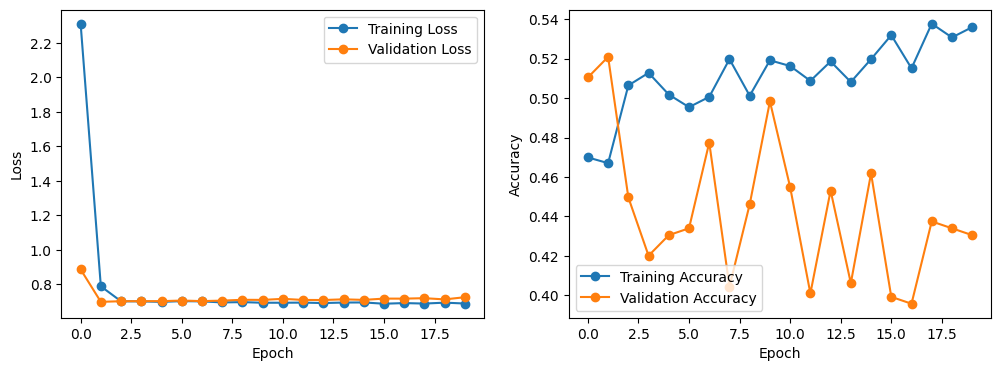

Final Training Loss:      0.6894
Final Validation Loss:    0.7260
Final Training Accuracy:  0.5359
Final Validation Accuracy:0.4306


In [49]:
x_arr = np.arange(num_epochs)
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, loss_history_train, '-o', label='Training Loss')
ax.plot(x_arr, loss_history_valid, '-o', label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, accuracy_history_train, '-o', label='Training Accuracy')
ax.plot(x_arr, accuracy_history_valid, '-o', label='Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

plt.show()

print("Final Training Loss:      {:.4f}".format(loss_history_train[-1]))
print("Final Validation Loss:    {:.4f}".format(loss_history_valid[-1]))
print("Final Training Accuracy:  {:.4f}".format(accuracy_history_train[-1]))
print("Final Validation Accuracy:{:.4f}".format(accuracy_history_valid[-1]))


In [50]:
X_list = []
y_list = []

for i in range(len(coil_dataset_test)):
    img, label = coil_dataset_test[i]
    X_list.append(img)
    y_list.append(label)


test_data = torch.stack(X_list).to(device)
test_targets = torch.tensor(y_list).to(device)


model.eval()
with torch.no_grad():
    test_pred = model(test_data)

is_correct = (torch.argmax(test_pred, dim=1) == test_targets).float()
print(f'Test Accuracy is: {is_correct.mean():.4f}')


Test Accuracy is: 0.4601


## Scotty's Contribution

## Amelia's Contribution